#📌 Extração

In [1]:
import requests
import shap
import tempfile
import math
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import gaussian_kde

In [2]:
#@title Carregamento dos dados
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json"

response = requests.get(url)
response.raise_for_status()  # garante que falhe rápido se der erro
data = response.json()
df = pd.DataFrame(data)
df

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
...,...,...,...,...,...,...
7262,9987-LUTYD,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
7263,9992-RRAMN,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
7264,9992-UJOEL,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
7265,9993-LHIEB,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Two year', 'PaperlessBilling': '..."


#🔧 Transformação

# Exploração, verificação de tipos, tradução e transformação dos dados

                                                 Dicionário das variáveis
| Variável               | Descrição                                                  | Tipo       | Possíveis Valores / Notas                                                |
| ---------------------- | ---------------------------------------------------------- | ---------- | ------------------------------------------------------------------------ |
| **ID**                 | Identificador único do cliente                             | Texto      | Exemplo: "0002-ORFBO"                                                    |
| **Evasao**             | Indica se o cliente cancelou o serviço (evasão)            | Binária    | Não (0), Sim (1)                                                         |
| **genero**             | Sexo do cliente                                            | Categórica | "Masculino", "Feminino"                                                  |
| **Senior**             | Indica se o cliente é idoso                                | Binária    | Não (0), Sim (1)                                                         |
| **Conjunge**           | Indica se o cliente possui cônjuge                         | Binária    | Não (0), Sim (1)                                                         |
| **Dependentes**        | Indica se o cliente possui dependentes                     | Binária    | Não (0), Sim (1)                                                         |
| **Permanência(Meses)** | Tempo (em meses) que o cliente está com a empresa          | Numérica   | Exemplo: 5, 12, 24                                                       |
| **Telefone**           | Indica se o cliente possui serviço telefônico              | Binária    | Não (0), Sim (1)                                                         |
| **MultiplasLinhas**    | Indica se o cliente possui múltiplas linhas telefônicas    | Binária    | Não (0), Sim (1)                                                         |
| **ServicoInternet**    | Tipo de serviço de internet contratado                     | Categórica | "DSL", "Fibra ótica", "Sem internet"                                     |
| **Seguranca**          | Indica se o cliente possui segurança online | Binária | Não (0), Sim (1)
| **BackupOnline**       | Indica se o cliente possui backup online                   | Binária    | Não (0), Sim (1)                                                         |
| **Protecao**           | Indica se o cliente possui proteção de dispositivo         | Binária    | Não (0), Sim (1)                                                         |
| **Suporte**            | Indica se o cliente possui suporte técnico                 | Binária    | Não (0), Sim (1)                                                         |
| **TV**                 | Indica se o cliente possui serviço de TV por streaming     | Binária    | Não (0), Sim (1)                                                         |
| **Filmes**             | Indica se o cliente possui serviço de filmes por streaming | Binária    | Não (0), Sim (1)                                                         |
| **Contrato**           | Tipo de contrato do cliente                                | Categórica | "Mensal", "Anual", "Bienal"                                              |
| **Fatura**             | Indica se o cliente optou por faturamento sem papel        | Binária    | Não (0), Sim (1)                                                         |
| **MetodoPagamento**    | Método de pagamento utilizado pelo cliente                 | Categórica | Exemplo: "Cheque eletrônico", "Cheque enviado", "Transferência bancária" |
| **CobrancaMensal**     | Valor cobrado mensalmente                                  | Numérica   | Exemplo: 29.85, 56.95                                                    |
| **CobrancaTotal**      | Valor total cobrado até o momento                          | Numérica   | Exemplo: 1889.5                                                          |

## Normalização e tradução das informações

In [3]:
df = pd.json_normalize(data)
df

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65


In [4]:
#@title Verificação de categorias nas colunas categóricas
categorical_cols = ['Churn',
      'customer.gender',
      'customer.SeniorCitizen',
      'customer.Partner',
      'customer.Dependents',
      'phone.PhoneService',
      'phone.MultipleLines',
      'internet.InternetService',
      'internet.OnlineSecurity',
      'internet.OnlineBackup',
      'internet.DeviceProtection',
      'internet.TechSupport',
      'internet.StreamingTV',
      'internet.StreamingMovies',
      'account.Contract',
      'account.PaperlessBilling',
      'account.PaymentMethod']

for col in categorical_cols:
    if col in df.columns:
        print(f"\nValores em:")
        counts = df[col].value_counts(dropna=False)
        print(counts)


Valores em:
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Valores em:
customer.gender
Male      3675
Female    3592
Name: count, dtype: int64

Valores em:
customer.SeniorCitizen
0    6085
1    1182
Name: count, dtype: int64

Valores em:
customer.Partner
No     3749
Yes    3518
Name: count, dtype: int64

Valores em:
customer.Dependents
No     5086
Yes    2181
Name: count, dtype: int64

Valores em:
phone.PhoneService
Yes    6560
No      707
Name: count, dtype: int64

Valores em:
phone.MultipleLines
No                  3495
Yes                 3065
No phone service     707
Name: count, dtype: int64

Valores em:
internet.InternetService
Fiber optic    3198
DSL            2488
No             1581
Name: count, dtype: int64

Valores em:
internet.OnlineSecurity
No                     3608
Yes                    2078
No internet service    1581
Name: count, dtype: int64

Valores em:
internet.OnlineBackup
No                     3182
Yes                    2504
No internet

In [5]:
  colunas_simplificadas_en = {
      'customerID': 'ID',
      'Churn': 'Evasao',
      'customer.gender': 'genero',
      'customer.SeniorCitizen': 'Senior',
      'customer.Partner': 'Conjunge',
      'customer.Dependents': 'Dependentes',
      'customer.tenure': 'Permanência(Meses)',
      'phone.PhoneService': 'Telefone',
      'phone.MultipleLines': 'MultiplasLinhas',
      'internet.InternetService': 'ServicoInternet',
      'internet.OnlineSecurity': 'Seguranca',
      'internet.OnlineBackup': 'BackupOnline',
      'internet.DeviceProtection': 'Protecao',
      'internet.TechSupport': 'Suporte',
      'internet.StreamingTV': 'TV',
      'internet.StreamingMovies': 'Filmes',
      'account.Contract': 'Contrato',
      'account.PaperlessBilling': 'Fatura',
      'account.PaymentMethod': 'MetodoPagamento',
      'account.Charges.Monthly': 'CobrancaMensal',
      'account.Charges.Total': 'CobrancaTotal'
  }

  df.rename(columns=colunas_simplificadas_en, inplace=True)

  # Dicionários para tradução de valores
  map_genero = {'Male': 'Masculino', 'Female': 'Feminino'}
  map_binario = {'Yes': 'Sim', **dict.fromkeys(['No', 'No phone service', 'No internet service'], 'Não')}
  map_internet = {'DSL': 'DSL', 'Fiber optic': 'Fibra ótica', 'No': 'Sem internet'}
  map_contrato = {'Month-to-month': 'Mensal', 'One year': 'Anual', 'Two year': 'Bienal'}
  map_metodo_pagamento = {'Electronic check': 'Cheque eletrônico', 'Mailed check': 'Cheque por correio', 'Bank transfer (automatic)': 'Transferência bancária (automática)', 'Credit card (automatic)': 'Cartão de crédito (automático)'}

  # Aplicar traduções
  if 'genero' in df.columns:
      df['genero'] = df['genero'].map(map_genero)

  for col in ['Conjunge', 'Dependentes', 'Telefone', 'MultiplasLinhas', 'Seguranca',
              'BackupOnline', 'Protecao', 'Suporte',
              'TV', 'Filmes', 'Fatura', 'Evasao']:
      if col in df.columns:
          df[col] = df[col].map(map_binario)

  if 'ServicoInternet' in df.columns:
      df['ServicoInternet'] = df['ServicoInternet'].map(map_internet)

  if 'Contrato' in df.columns:
      df['Contrato'] = df['Contrato'].map(map_contrato)

  if 'MetodoPagamento' in df.columns:
      df['MetodoPagamento'] = df['MetodoPagamento'].map(map_metodo_pagamento)

  df

,ID,Evasao,genero,Senior,Conjunge,Dependentes,Permanência(Meses),Telefone,MultiplasLinhas,ServicoInternet,...,BackupOnline,Protecao,Suporte,TV,Filmes,Contrato,Fatura,MetodoPagamento,CobrancaMensal,CobrancaTotal
0,0002-ORFBO,Não,Feminino,0,Sim,Sim,9,Sim,Não,DSL,...,Sim,Não,Sim,Sim,Não,Anual,Sim,Cheque por correio,65.60,593.3
1,0003-MKNFE,Não,Masculino,0,Não,Não,9,Sim,Sim,DSL,...,Não,Não,Não,Não,Sim,Mensal,Não,Cheque por correio,59.90,542.4
2,0004-TLHLJ,Sim,Masculino,0,Não,Não,4,Sim,Não,Fibra ótica,...,Não,Sim,Não,Não,Não,Mensal,Sim,Cheque eletrônico,73.90,280.85
3,0011-IGKFF,Sim,Masculino,1,Sim,Não,13,Sim,Não,Fibra ótica,...,Sim,Sim,Não,Sim,Sim,Mensal,Sim,Cheque eletrônico,98.00,1237.85
4,0013-EXCHZ,Sim,Feminino,1,Sim,Não,3,Sim,Não,Fibra ótica,...,Não,Não,Sim,Sim,Não,Mensal,Sim,Cheque por correio,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,Não,Feminino,0,Não,Não,13,Sim,Não,DSL,...,Não,Não,Sim,Não,Não,Anual,Não,Cheque por correio,55.15,742.9
7263,9992-RRAMN,Sim,Masculino,0,Sim,Não,22,Sim,Sim,Fibra ótica,...,Não,Não,Não,Não,Sim,Mensal,Sim,Cheque eletrônico,85.10,1873.7
7264,9992-UJOEL,Não,Masculino,0,Não,Não,2,Sim,Não,DSL,...,Sim,Não,Não,Não,Não,Mensal,Sim,Cheque por correio,50.30,92.75
7265,9993-LHIEB,Não,Masculino,0,Sim,Sim,67,Sim,Não,DSL,...,Não,Sim,Sim,Não,Sim,Bienal,Não,Cheque por correio,67.85,4627.65


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7267 non-null   object 
 1   Evasao              7043 non-null   object 
 2   genero              7267 non-null   object 
 3   Senior              7267 non-null   int64  
 4   Conjunge            7267 non-null   object 
 5   Dependentes         7267 non-null   object 
 6   Permanência(Meses)  7267 non-null   int64  
 7   Telefone            7267 non-null   object 
 8   MultiplasLinhas     7267 non-null   object 
 9   ServicoInternet     7267 non-null   object 
 10  Seguranca           7267 non-null   object 
 11  BackupOnline        7267 non-null   object 
 12  Protecao            7267 non-null   object 
 13  Suporte             7267 non-null   object 
 14  TV                  7267 non-null   object 
 15  Filmes              7267 non-null   object 
 16  Contra

## Verificação e tratamento de Inconsistências

In [7]:
#@title Contagem de valores ausentes por coluna
print("\nValores ausentes por coluna:")
print(df.isna().sum())


Valores ausentes por coluna:
ID                      0
Evasao                224
genero                  0
Senior                  0
Conjunge                0
Dependentes             0
Permanência(Meses)      0
Telefone                0
MultiplasLinhas         0
ServicoInternet         0
Seguranca               0
BackupOnline            0
Protecao                0
Suporte                 0
TV                      0
Filmes                  0
Contrato                0
Fatura                  0
MetodoPagamento         0
CobrancaMensal          0
CobrancaTotal           0
dtype: int64


In [8]:
#@title Contagem de duplicatas
duplicatas = df.duplicated().sum()
print(f"\nNúmero de linhas duplicadas: {duplicatas}")


Número de linhas duplicadas: 0


In [9]:
#@title Verificação de categorias nas colunas categóricas
categorical_cols = ['genero', 'Conjunge', 'Dependentes', 'Telefone', 'MultiplasLinhas', 'Seguranca',
                    'BackupOnline', 'Protecao', 'Suporte', 'TV', 'Filmes', 'Fatura',
                    'ServicoInternet', 'Contrato', 'MetodoPagamento', 'Evasao']

for col in categorical_cols:
    if col in df.columns:
        print(f"\nValores em:")
        counts = df[col].value_counts(dropna=False)
        print(counts)


Valores em:
genero
Masculino    3675
Feminino     3592
Name: count, dtype: int64

Valores em:
Conjunge
Não    3749
Sim    3518
Name: count, dtype: int64

Valores em:
Dependentes
Não    5086
Sim    2181
Name: count, dtype: int64

Valores em:
Telefone
Sim    6560
Não     707
Name: count, dtype: int64

Valores em:
MultiplasLinhas
Não    4202
Sim    3065
Name: count, dtype: int64

Valores em:
Seguranca
Não    5189
Sim    2078
Name: count, dtype: int64

Valores em:
BackupOnline
Não    4763
Sim    2504
Name: count, dtype: int64

Valores em:
Protecao
Não    4776
Sim    2491
Name: count, dtype: int64

Valores em:
Suporte
Não    5163
Sim    2104
Name: count, dtype: int64

Valores em:
TV
Não    4477
Sim    2790
Name: count, dtype: int64

Valores em:
Filmes
Não    4451
Sim    2816
Name: count, dtype: int64

Valores em:
Fatura
Sim    4311
Não    2956
Name: count, dtype: int64

Valores em:
ServicoInternet
Fibra ótica     3198
DSL             2488
Sem internet    1581
Name: count, dtype: int64

Val

In [10]:
pd.set_option('future.no_silent_downcasting', True)
df_binario = (
    df.replace({'Sim': 1, 'Não': 0, 'sim': 1, 'não': 0})
      .infer_objects(copy=False)
)

df_binario.head()

,ID,Evasao,genero,Senior,Conjunge,Dependentes,Permanência(Meses),Telefone,MultiplasLinhas,ServicoInternet,...,BackupOnline,Protecao,Suporte,TV,Filmes,Contrato,Fatura,MetodoPagamento,CobrancaMensal,CobrancaTotal
0,0002-ORFBO,0.0,Feminino,0,1,1,9,1,0,DSL,...,1,0,1,1,0,Anual,1,Cheque por correio,65.6,593.3
1,0003-MKNFE,0.0,Masculino,0,0,0,9,1,1,DSL,...,0,0,0,0,1,Mensal,0,Cheque por correio,59.9,542.4
2,0004-TLHLJ,1.0,Masculino,0,0,0,4,1,0,Fibra ótica,...,0,1,0,0,0,Mensal,1,Cheque eletrônico,73.9,280.85
3,0011-IGKFF,1.0,Masculino,1,1,0,13,1,0,Fibra ótica,...,1,1,0,1,1,Mensal,1,Cheque eletrônico,98.0,1237.85
4,0013-EXCHZ,1.0,Feminino,1,1,0,3,1,0,Fibra ótica,...,0,0,1,1,0,Mensal,1,Cheque por correio,83.9,267.4


In [11]:
df_binario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7267 non-null   object 
 1   Evasao              7043 non-null   float64
 2   genero              7267 non-null   object 
 3   Senior              7267 non-null   int64  
 4   Conjunge            7267 non-null   int64  
 5   Dependentes         7267 non-null   int64  
 6   Permanência(Meses)  7267 non-null   int64  
 7   Telefone            7267 non-null   int64  
 8   MultiplasLinhas     7267 non-null   int64  
 9   ServicoInternet     7267 non-null   object 
 10  Seguranca           7267 non-null   int64  
 11  BackupOnline        7267 non-null   int64  
 12  Protecao            7267 non-null   int64  
 13  Suporte             7267 non-null   int64  
 14  TV                  7267 non-null   int64  
 15  Filmes              7267 non-null   int64  
 16  Contra

### Análise Estatística dos valores nulos

In [12]:
# Total de registros
total_registros = len(df)

# Quantidade de valores ausentes na coluna Evasao
valores_ausentes = df['Evasao'].isna().sum()

# Percentual de ausentes
percentual_ausentes = (valores_ausentes / total_registros) * 100

print(f"Total de registros: {total_registros}")
print(f"Valores ausentes em 'Evasao': {valores_ausentes}")
print(f"Percentual de ausentes: {percentual_ausentes:.2f}%")

# Interpretação
if percentual_ausentes < 5:
    print("O percentual de dados ausentes é baixo (<5%), sendo pouco provável que afete significativamente os resultados da análise.")
else:
    print("O percentual de dados ausentes é relevante, devendo ser tratado com mais cautela.")

Total de registros: 7267
Valores ausentes em 'Evasao': 224
Percentual de ausentes: 3.08%
O percentual de dados ausentes é baixo (<5%), sendo pouco provável que afete significativamente os resultados da análise.


In [13]:
# Cálculo da taxa de evasão considerando apenas registros válidos
taxa_completa = df_binario['Evasao'].dropna().mean()*100

# Criando um cenário onde valores ausentes são tratados como "não evadidos"
taxa_com_zeros = df_binario['Evasao'].fillna(0).mean()*100

# Criando um cenário onde valores ausentes são tratados como "evadidos"
taxa_com_uns = df_binario['Evasao'].fillna(1).mean()*100

print(f"Taxa de evasão (sem ausentes): {taxa_completa:.4f}")
print(f"Taxa de evasão (ausentes = 0): {taxa_com_zeros:.4f}")
print(f"Taxa de evasão (ausentes = 1): {taxa_com_uns:.4f}")

# Diferença percentual entre cenários
dif_zeros = abs(taxa_completa - taxa_com_zeros) / taxa_completa * 100
dif_uns = abs(taxa_completa - taxa_com_uns) / taxa_completa * 100

print(f"Variação ao tratar ausentes como 0: {dif_zeros:.2f}%")
print(f"Variação ao tratar ausentes como 1: {dif_uns:.2f}%")

Taxa de evasão (sem ausentes): 26.5370
Taxa de evasão (ausentes = 0): 25.7190
Taxa de evasão (ausentes = 1): 28.8014
Variação ao tratar ausentes como 0: 3.08%
Variação ao tratar ausentes como 1: 8.53%


Justificativa Técnica – Tratamento de Valores Ausentes na Coluna *Evasão*

Durante a análise exploratória dos dados, identificou-se que a coluna **Evasão** contém **227 registros com valores ausentes**.
Para avaliar o impacto desses registros na métrica de taxa de evasão, foi realizado um **teste de sensibilidade**, comparando três cenários:

| Cenário                              | Taxa de Evasão | Variação (%) |
| ------------------------------------ | -------------: | -----------: |
| Sem ausentes                         |         26,54% |            — |
| Ausentes tratados como **"Não" (0)** |         25,72% |        3,08% |
| Ausentes tratados como **"Sim" (1)** |         28,80% |        8,53% |

**Interpretação dos resultados:**

* Ao tratar ausentes como **"Não"**, a variação é mínima (**3,08%**) em relação à taxa original, permanecendo dentro do intervalo aceitável (<5%) para análises exploratórias.
* Ao tratar ausentes como **"Sim"**, observa-se uma variação mais expressiva (**8,53%**), o que pode levar a interpretações distorcidas sobre o comportamento de evasão.

**Decisão:**
Opta-se por não atribuir valor aos registros ausentes na coluna *Evasão*, apenas remover as respectivas linhas.
Essa escolha minimiza o impacto estatístico, preserva a representatividade do conjunto de dados e evita distorções no cálculo da taxa de evasão.

**Conclusão:**
A adoção desse critério garante maior consistência na análise, mantendo a comparabilidade dos resultados e reduzindo o risco de vieses interpretativos.

### Tratamento nulos e geração de novas bases

In [14]:
if 'CobrancaTotal' in df.columns:
    df['CobrancaTotal'] = pd.to_numeric(df['CobrancaTotal'], errors='coerce').fillna(0.0).astype(float)

if 'Evasao' in df.columns:
    df = df[df['Evasao'].notna() & (df['Evasao'].astype(str).str.strip() != '')]

df

,ID,Evasao,genero,Senior,Conjunge,Dependentes,Permanência(Meses),Telefone,MultiplasLinhas,ServicoInternet,...,BackupOnline,Protecao,Suporte,TV,Filmes,Contrato,Fatura,MetodoPagamento,CobrancaMensal,CobrancaTotal
0,0002-ORFBO,Não,Feminino,0,Sim,Sim,9,Sim,Não,DSL,...,Sim,Não,Sim,Sim,Não,Anual,Sim,Cheque por correio,65.60,593.30
1,0003-MKNFE,Não,Masculino,0,Não,Não,9,Sim,Sim,DSL,...,Não,Não,Não,Não,Sim,Mensal,Não,Cheque por correio,59.90,542.40
2,0004-TLHLJ,Sim,Masculino,0,Não,Não,4,Sim,Não,Fibra ótica,...,Não,Sim,Não,Não,Não,Mensal,Sim,Cheque eletrônico,73.90,280.85
3,0011-IGKFF,Sim,Masculino,1,Sim,Não,13,Sim,Não,Fibra ótica,...,Sim,Sim,Não,Sim,Sim,Mensal,Sim,Cheque eletrônico,98.00,1237.85
4,0013-EXCHZ,Sim,Feminino,1,Sim,Não,3,Sim,Não,Fibra ótica,...,Não,Não,Sim,Sim,Não,Mensal,Sim,Cheque por correio,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,Não,Feminino,0,Não,Não,13,Sim,Não,DSL,...,Não,Não,Sim,Não,Não,Anual,Não,Cheque por correio,55.15,742.90
7263,9992-RRAMN,Sim,Masculino,0,Sim,Não,22,Sim,Sim,Fibra ótica,...,Não,Não,Não,Não,Sim,Mensal,Sim,Cheque eletrônico,85.10,1873.70
7264,9992-UJOEL,Não,Masculino,0,Não,Não,2,Sim,Não,DSL,...,Sim,Não,Não,Não,Não,Mensal,Sim,Cheque por correio,50.30,92.75
7265,9993-LHIEB,Não,Masculino,0,Sim,Sim,67,Sim,Não,DSL,...,Não,Sim,Sim,Não,Sim,Bienal,Não,Cheque por correio,67.85,4627.65


## Criação da coluna Cobrança Diária

In [15]:
#@title Criação da coluna Cobrança Diária
df = df.copy()
df.loc[:, 'CobrancaDiaria'] = df['CobrancaMensal'] / 30

# Conferir as primeiras linhas
print(df[['CobrancaMensal', 'CobrancaDiaria']].head())

   CobrancaMensal  CobrancaDiaria
0            65.6        2.186667
1            59.9        1.996667
2            73.9        2.463333
3            98.0        3.266667
4            83.9        2.796667


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7043 non-null   object 
 1   Evasao              7043 non-null   object 
 2   genero              7043 non-null   object 
 3   Senior              7043 non-null   int64  
 4   Conjunge            7043 non-null   object 
 5   Dependentes         7043 non-null   object 
 6   Permanência(Meses)  7043 non-null   int64  
 7   Telefone            7043 non-null   object 
 8   MultiplasLinhas     7043 non-null   object 
 9   ServicoInternet     7043 non-null   object 
 10  Seguranca           7043 non-null   object 
 11  BackupOnline        7043 non-null   object 
 12  Protecao            7043 non-null   object 
 13  Suporte             7043 non-null   object 
 14  TV                  7043 non-null   object 
 15  Filmes              7043 non-null   object 
 16  Contrato   

In [17]:
pd.set_option('future.no_silent_downcasting', True)
df_binario = (
    df.replace({'Sim': 1, 'Não': 0, 'sim': 1, 'não': 0})
      .infer_objects(copy=False)
)

df_binario.head()

,ID,Evasao,genero,Senior,Conjunge,Dependentes,Permanência(Meses),Telefone,MultiplasLinhas,ServicoInternet,...,Protecao,Suporte,TV,Filmes,Contrato,Fatura,MetodoPagamento,CobrancaMensal,CobrancaTotal,CobrancaDiaria
0,0002-ORFBO,0,Feminino,0,1,1,9,1,0,DSL,...,0,1,1,0,Anual,1,Cheque por correio,65.6,593.30,2.186667
1,0003-MKNFE,0,Masculino,0,0,0,9,1,1,DSL,...,0,0,0,1,Mensal,0,Cheque por correio,59.9,542.40,1.996667
2,0004-TLHLJ,1,Masculino,0,0,0,4,1,0,Fibra ótica,...,1,0,0,0,Mensal,1,Cheque eletrônico,73.9,280.85,2.463333
3,0011-IGKFF,1,Masculino,1,1,0,13,1,0,Fibra ótica,...,1,0,1,1,Mensal,1,Cheque eletrônico,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Feminino,1,1,0,3,1,0,Fibra ótica,...,0,1,1,0,Mensal,1,Cheque por correio,83.9,267.40,2.796667


In [18]:
df_binario.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7043 non-null   object 
 1   Evasao              7043 non-null   int64  
 2   genero              7043 non-null   object 
 3   Senior              7043 non-null   int64  
 4   Conjunge            7043 non-null   int64  
 5   Dependentes         7043 non-null   int64  
 6   Permanência(Meses)  7043 non-null   int64  
 7   Telefone            7043 non-null   int64  
 8   MultiplasLinhas     7043 non-null   int64  
 9   ServicoInternet     7043 non-null   object 
 10  Seguranca           7043 non-null   int64  
 11  BackupOnline        7043 non-null   int64  
 12  Protecao            7043 non-null   int64  
 13  Suporte             7043 non-null   int64  
 14  TV                  7043 non-null   int64  
 15  Filmes              7043 non-null   int64  
 16  Contrato   

## Identificando colunas importantes e corrrelacionamento com Evasão

In [19]:
# Garantir que Evasao seja numérica
df_binario['Evasao'] = pd.to_numeric(df_binario['Evasao'], errors='coerce')

# Calcular novamente a correlação
df_num = df_binario.select_dtypes(include=['number'])
if 'Evasao' in df_num.columns:
    corr = df_num.corr(numeric_only=True)['Evasao'].drop('Evasao')
    corr_abs = corr.abs().sort_values(ascending=False)
    print("Correlação com 'Evasao' (variáveis numéricas):")
    print(corr_abs)

Correlação com 'Evasao' (variáveis numéricas):
Permanência(Meses)    0.352229
CobrancaTotal         0.198324
CobrancaMensal        0.193356
CobrancaDiaria        0.193356
Fatura                0.191825
Seguranca             0.171226
Suporte               0.164674
Dependentes           0.164221
Senior                0.150889
Conjunge              0.150448
BackupOnline          0.082255
Protecao              0.066160
TV                    0.063228
Filmes                0.061382
MultiplasLinhas       0.040102
Telefone              0.011942
Name: Evasao, dtype: float64


### **Resumo**

|           Variável |    Correlação (r) | Interpretação rápida            |
| -----------------: | ----------------: | ------------------------------- |
| Permanência(Meses) | 0.352229 (35.22%) | **Maior correlação (moderada)** |
|      CobrancaTotal | 0.198324 (19.83%) | baixa–moderada                  |
|     CobrancaMensal | 0.193356 (19.34%) | baixa–moderada                  |
|     CobrancaDiaria | 0.193356 (19.34%) | baixa–moderada                  |
|             Fatura | 0.191825 (19.18%) | baixa–moderada                  |
|          Seguranca | 0.171226 (17,12%) | baixa–moderada                  |
|            Suporte | 0.164674 (16.47%) | pequena                         |
|        Dependentes | 0.164221 (16.42%) | pequena                         |
|             Senior | 0.150889 (15.09%) | pequena                         |
|           Conjunge | 0.150448 (15.04%) | pequena                         |
|       BackupOnline |  0.082255 (8.23%) | muito pequena                   |
|           Protecao |  0.066160 (6.62%) | muito pequena                   |
|                 TV |  0.063228 (6.32%) | muito pequena                   |
|             Filmes |  0.061382 (6.14%) | muito pequena                   |
|    MultiplasLinhas |  0.040102 (4.01%) | desprezível                     |
|           Telefone |  0.011942 (1.19%) | desprezível                     |

**Como interpretar o tamanho (regra prática):**

* > 0.50 = forte; 0.30–0.50 = moderada; 0.10–0.30 = pequena; <0.10 ≈ muito fraca/desprezível.

---

# Interpretação detalhada e hipóteses

1. **Permanência(Meses) — r = 0.352 (maior associação)**

   * Significado estatístico: é a variável numérica mais associada à Evasao.
   * *Direção:* porque `Evasao` está codada como 1 = *Sim* (evadiu), r positivo significa que **valores maiores de Permanência estão associados a maior probabilidade de Evasao**.
   * *Hipóteses:* isso é contra a intuição clássica (esperaríamos Evasao maior em clientes novos). Possíveis explicações: (a) variabilidade/erro na variável; (b) clientes muito antigos acumulam faturas/contratos que levam à saída; (c) contratualizações antigas com preços diferentes; (d) presença de clientes “inativos” que só aparecem com Permanência alta.
   * **Ação imediata:** verificar médias/medianas de Permanência por grupo (evadiu x não evadiu) e plotar Evasao rate por faixa de Permanência (bins) — pode revelar relação não-linear (ex.: pico em 12, 24 meses).

2. **CobrancaTotal / CobrancaMensal / CobrancaDiaria — ~0.19**
    
    * A inclusão da **CobrancaDiaria** confirma que ela é diretamente proporcional à mensal e, portanto, herda a mesma correlação.
    * Indicam que cobranças mais altas estão levemente associadas a maior evasão.
    * Atenção: pode haver efeito da `Permanência(Meses)` na `CobrancaTotal` (multicolinearidade).

3. **Fatura (paperless billing) — \~0.19**

   * Se `Fatura` = 1 significa “sem papel”, então clientes com faturamento sem papel estão **mais associados** a Evasao. Possíveis interpretações: clientes digitais trocam mais fácil, ou Fatura Digital está correlacionado com perfil mais jovem/mais sensível a preço.
   * **Ação prática:** investigar perfil das “Faturas” (idade, contrato, CobrancaMensal). Campanhas de retenção específicas (comunicação, ofertas) para esse segmento podem ter retorno.

4. **Suporte Técnico — \~0.164 (presença de suporte associada a maior Evasao)**

   * Contraditório a princípio — esperaríamos suporte reduzir Evasao. Hipóteses: clientes que compram suporte podem estar com problemas frequentes (portanto mais propensos a sair), ou existe confusão de codificação (ex.: 1 = sem suporte). Verificar `value_counts()` dessa coluna.
   * **Ação:** checar se 1 realmente significa “tem suporte”; analisar Evasao entre clientes com/sem suporte (tabela cruzada).

5. **Dependentes / Senior / Conjunge — \~0.15**

   * São associações pequenas. Possível que sejam proxies de perfil demográfico/uso (ex.: famílias usam mais serviços ou aceitam pacotes que afetam Evasao).

6. **Outras features (BackupOnline, Protecao, TV, Filmes, MultiplasLinhas, Telefone)**

   * Correlações muito baixas — pouca relação linear direta com Evasao. Não quer dizer que sejam irrelevantes (podem ter efeito em interação ou não-linear), mas sozinhas não explicam muito.
---

# Recomendações práticas (priorizadas)

1. **Verificações rápidas (prioridade alta)**

   * Gerar `groupby` e `plots`: média/mediana de `Permanência` por Evasao, Evasao rate por bin de `Permanência`, Evasao rate por quantil de `CobrancaMensal`.

2. **Análise estatística/ML (prioridade média)**

   * Rodar um **modelo de regressão logística** (com `statsmodels`) para obter odds ratios ajustados (ajusta por confusores).
   * Calcular **mutual\_info\_classif** para um ranking que trate variáveis categóricas e numéricas de forma conjunta.
   * Treinar um modelo árvore (RandomForest / XGBoost) e usar **SHAP** para interpretar importâncias e efeitos não-lineares.

3. **Ações de negócio (prioridade prática)**

   * Se Permanência realmente aumenta Evasao: investigar contratos antigos e motivos de salida (pesquisa com clientes de longa data). Programas de fidelidade para clientes antigos.
   * Se cobranças altas aumentam Evasao: analisar sensibilidade de preço — oferecer pacotes alternativos, descontos fidelidade.
   * Para clientes com `Fatura=paperless` e/ou `Suporte=1`: campanhas personalizadas (ofertas, check-in proativo, pesquisa de satisfação).

#📊 Carga e análise

## Análise Descritiva

In [20]:
#@title Estatísticas básicas
numeric_cols = ['Permanência(Meses)', 'CobrancaMensal', 'CobrancaTotal', 'CobrancaDiaria']
desc_stats = df[numeric_cols].describe().T

# Renomear colunas para português
desc_stats.rename(columns={
    'count': 'contagem',
    'mean': 'media',
    'std': 'desvio_padrao',
    'min': 'minimo',
    '25%': 'Q1',
    '50%': 'mediana',
    '75%': 'Q3',
    'max': 'maximo'
}, inplace=True)

# Adicionar assimetria e curtose
desc_stats['assimetria'] = df[numeric_cols].skew()
desc_stats['curtose'] = df[numeric_cols].kurt()

print("\n📊 Estatísticas descritivas detalhadas:")
print(desc_stats)


📊 Estatísticas descritivas detalhadas:
                    contagem        media  desvio_padrao     minimo  \
Permanência(Meses)    7043.0    32.371149      24.559481   0.000000   
CobrancaMensal        7043.0    64.761692      30.090047  18.250000   
CobrancaTotal         7043.0  2279.734304    2266.794470   0.000000   
CobrancaDiaria        7043.0     2.158723       1.003002   0.608333   

                            Q1   mediana        Q3       maximo  assimetria  \
Permanência(Meses)    9.000000    29.000    55.000    72.000000    0.239540   
CobrancaMensal       35.500000    70.350    89.850   118.750000   -0.220524   
CobrancaTotal       398.550000  1394.550  3786.600  8684.800000    0.963235   
CobrancaDiaria        1.183333     2.345     2.995     3.958333   -0.220524   

                     curtose  
Permanência(Meses) -1.387372  
CobrancaMensal     -1.257260  
CobrancaTotal      -0.228580  
CobrancaDiaria     -1.257260  


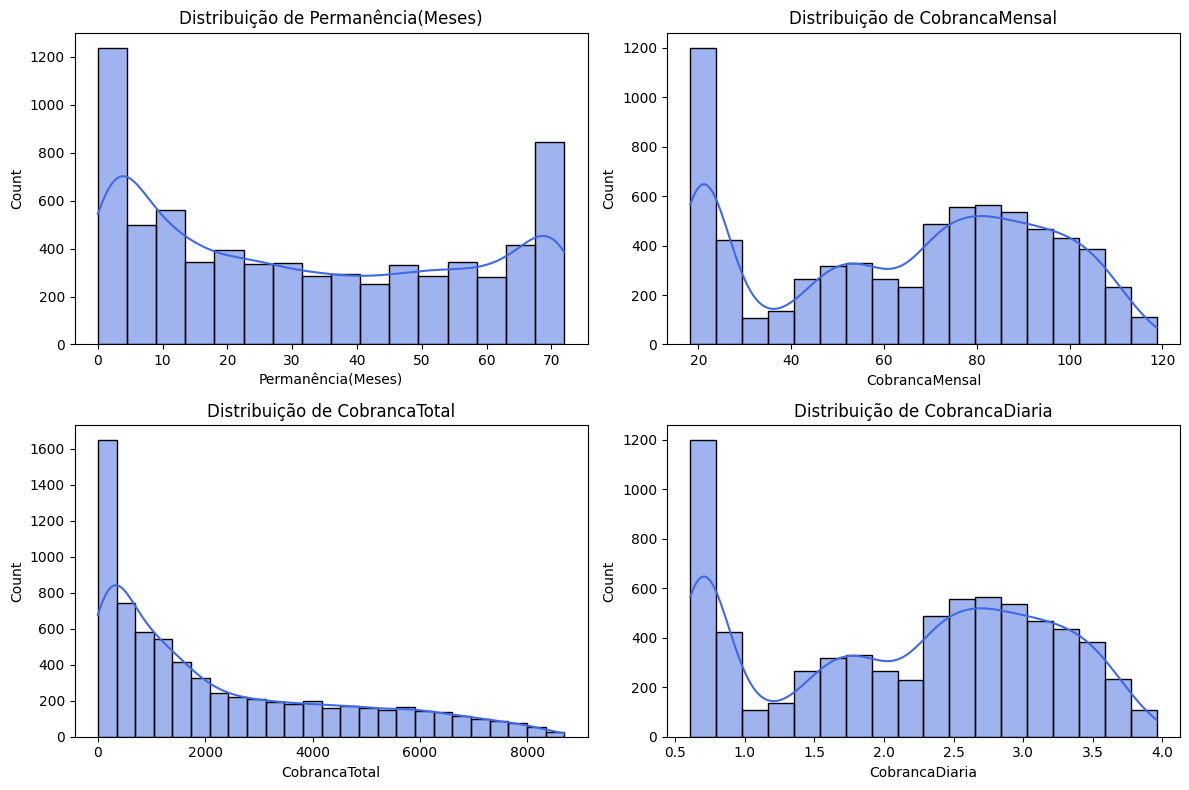

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(df[col], kde=True, ax=ax, color='royalblue')
    ax.set_title(f"Distribuição de {col}")
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

In [22]:
#@title Distribuição da Evasão
df.loc[:, 'Evasao'] = df['Evasao'].astype(str)

# Contagem e proporção
evasao_counts = df['Evasao'].value_counts()
evasao_percent = df['Evasao'].value_counts(normalize=True) * 100

print("📊 Contagem de clientes por evasão:")
print(evasao_counts)
print("\n📊 Proporção de clientes por evasão (%):")
print(evasao_percent.round(2))

📊 Contagem de clientes por evasão:
Evasao
Não    5174
Sim    1869
Name: count, dtype: int64

📊 Proporção de clientes por evasão (%):
Evasao
Não    73.46
Sim    26.54
Name: proportion, dtype: float64


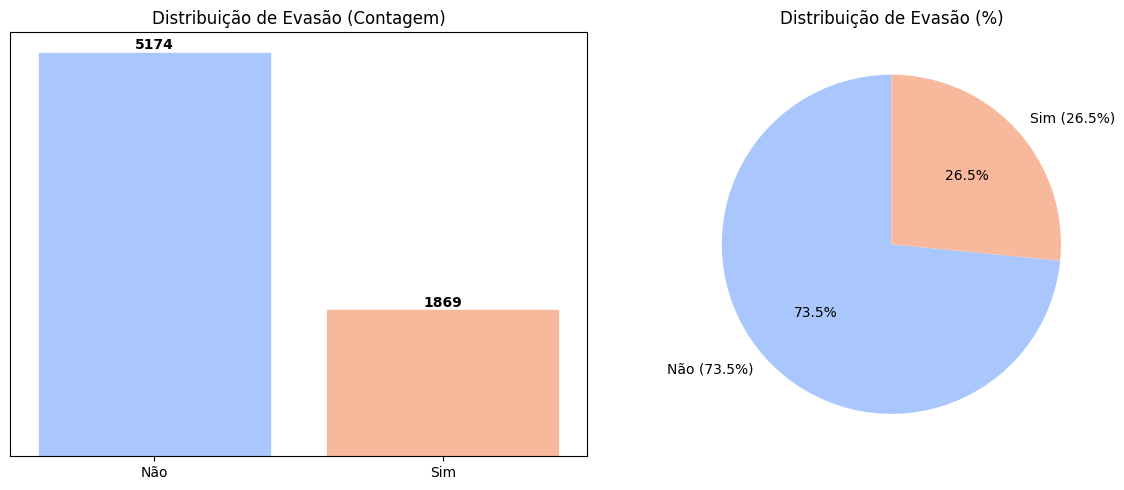

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir as cores com a paleta 'coolwarm' com número de cores igual ao número de categorias
cores = sns.color_palette('coolwarm', len(evasao_counts))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras com cor base neutra para evitar warning
sns.barplot(
    x=evasao_counts.index,
    y=evasao_counts.values,
    ax=axes[0],
    color='lightgray'  # cor base para depois colorir manualmente
)

# Colorir as barras manualmente com a paleta definida
for i, bar in enumerate(axes[0].patches):
    bar.set_color(cores[i])

axes[0].set_title('Distribuição de Evasão (Contagem)')

for i, v in enumerate(evasao_counts.values):
    axes[0].text(i, v + 50, f'{v}', ha='center', fontweight='bold')

# Remover ticks e valores do eixo y
axes[0].yaxis.set_visible(False)

# Remover título do eixo x
axes[0].set_xlabel('')

# Gráfico de pizza com as mesmas cores
axes[1].pie(
    evasao_counts,
    labels=[f"{label} ({perc:.1f}%)" for label, perc in zip(evasao_counts.index, evasao_percent)],
    colors=cores,
    autopct='%1.1f%%',
    startangle=90
)
axes[1].set_title('Distribuição de Evasão (%)')

plt.tight_layout()
plt.show()

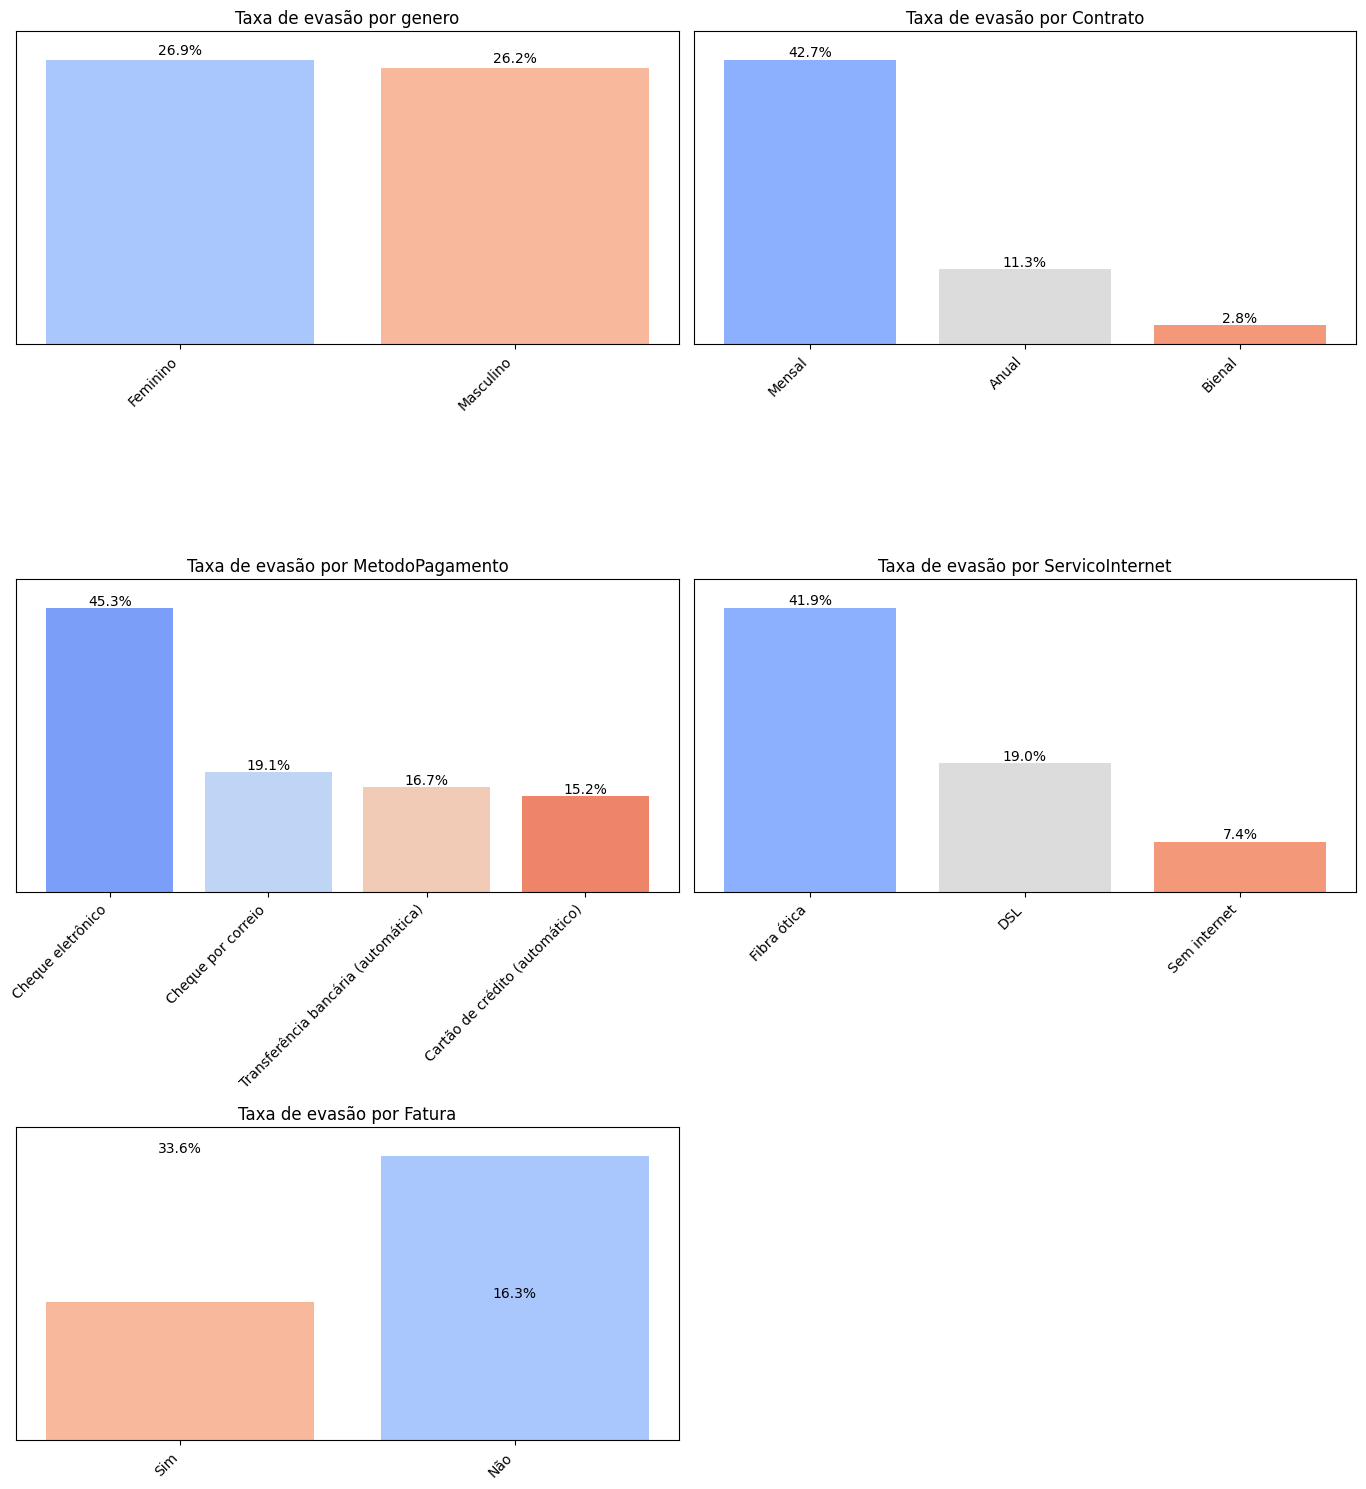

In [24]:
#@title Contagem de Evasão por Variáveis Categóricas

categorical_vars = ['genero', 'Contrato', 'MetodoPagamento', 'ServicoInternet', 'Fatura']

n = len(categorical_vars)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 5*rows))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    if var in df_binario.columns:
        taxa_evasao = df_binario.groupby(var)['Evasao'].mean().dropna().sort_values(ascending=False) * 100

        ax = axes[i]
        cores = sns.color_palette('coolwarm', len(taxa_evasao))
        barras = ax.bar(taxa_evasao.index, taxa_evasao.values, color=cores)

        ax.set_title(f"Taxa de evasão por {var}")
        ax.yaxis.set_ticks([])
        ax.set_ylim(0, max(taxa_evasao.values)*1.1)

        if var == 'Fatura' and var in df.columns:
            orig_labels = df[var].dropna().unique()
            label_map = {0: 'Não', 1: 'Sim'}
            labels_para_xticks = [label_map.get(x, str(x)) for x in taxa_evasao.index]

            ax.set_xticks(range(len(taxa_evasao)))
            ax.set_xticklabels(labels_para_xticks, rotation=45, ha='right')
        else:
            ax.set_xticks(range(len(taxa_evasao)))
            ax.set_xticklabels(taxa_evasao.index, rotation=45, ha='right')

        for j, val in enumerate(taxa_evasao.values):
            ax.text(j, val + 0.5, f"{val:.1f}%", ha='center')
    else:
        axes[i].axis('off')

for k in range(i+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [25]:
#@title Contagem de Evasão por Variáveis Numéricas
numeric_vars = ['CobrancaTotal', 'Permanência(Meses)', 'CobrancaMensal', 'CobrancaDiaria']
estatisticas = df_binario.groupby('Evasao')[numeric_vars].agg(['mean', 'median', 'std', 'count']).T
print(estatisticas)

Evasao                               0            1
CobrancaTotal      mean    2549.911442  1531.796094
                   median  1679.525000   703.550000
                   std     2329.954215  1890.822994
                   count   5174.000000  1869.000000
Permanência(Meses) mean      37.569965    17.979133
                   median    38.000000    10.000000
                   std       24.113777    19.531123
                   count   5174.000000  1869.000000
CobrancaMensal     mean      61.265124    74.441332
                   median    64.425000    79.650000
                   std       31.092648    24.666053
                   count   5174.000000  1869.000000
CobrancaDiaria     mean       2.042171     2.481378
                   median     2.147500     2.655000
                   std        1.036422     0.822202
                   count   5174.000000  1869.000000


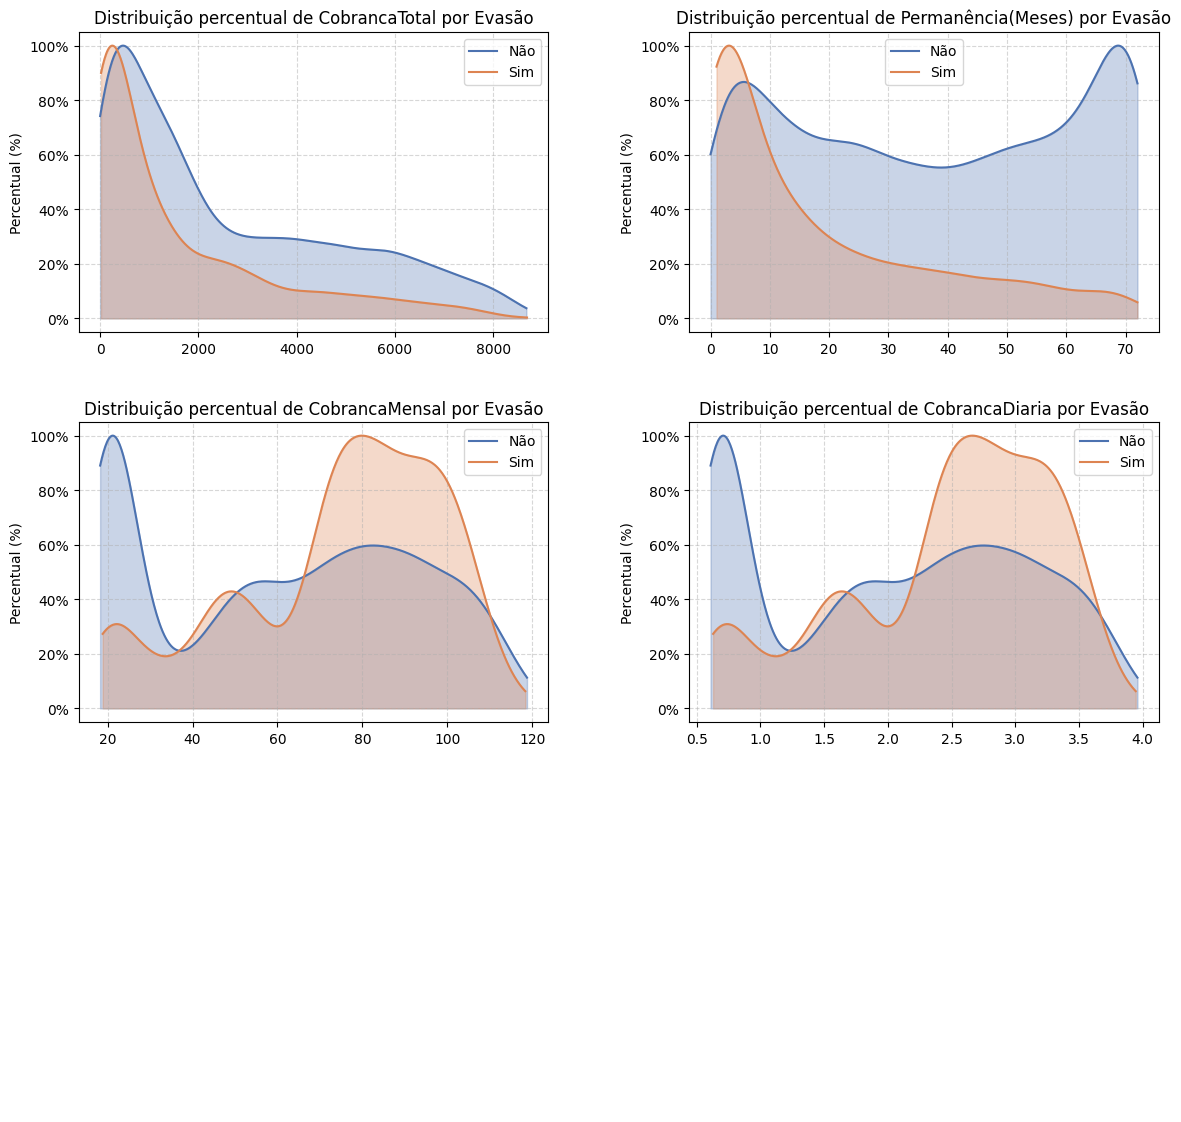

In [26]:
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    for evasion_class, color in zip([0, 1], ['#4c72b0', '#dd8452']):
        subset = df_binario[df_binario['Evasao'] == evasion_class][var].dropna()

        kde = gaussian_kde(subset)

        x_min, x_max = subset.min(), subset.max()
        x_vals = np.linspace(x_min, x_max, 500)

        y_vals = kde(x_vals)

        y_vals_percent = (y_vals / y_vals.max()) * 100

        label = 'Não' if evasion_class == 0 else 'Sim'

        ax.plot(x_vals, y_vals_percent, label=label, color=color)
        ax.fill_between(x_vals, 0, y_vals_percent, color=color, alpha=0.3)

    ax.set_title(f'Distribuição percentual de {var} por Evasão')
    ax.set_ylabel('Percentual (%)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)

plt.show()

#📄Relatorio Final

## 🧭 Introdução

Este projeto tem como objetivo analisar o comportamento dos clientes da TelecomX_BR e identificar os principais fatores que influenciam a evasão (churn). A evasão representa clientes que cancelaram seus serviços, impactando diretamente a receita da empresa. Através de técnicas de ciência de dados, buscamos entender esse fenômeno e propor estratégias para mitigá-lo.

---

## 🧹 Limpeza e Tratamento de Dados

As etapas de preparação dos dados incluíram:

- **Importação** dos dados a partir de arquivos JSON.
- **Renomeação de colunas** para facilitar a leitura e padronizar os nomes.
- **Tradução de valores** de inglês para português (ex.: "Male" → "Masculino").
- **Tratamento de valores ausentes**, especialmente na coluna `Evasao`.
- **Verificação de duplicatas**, sem registros repetidos.
- **Conversão de tipos**, como `CobrancaTotal` para numérico.

---

## 📈 Análise Exploratória de Dados

Realizamos diversas análises para entender o perfil dos clientes e os fatores associados à evasão:

- **Distribuição da evasão**: Cerca de 26% dos clientes apresentaram churn.
- **Gráficos de barras e pizza**: Visualizações por gênero, tipo de contrato, serviços contratados, entre outros.
- **Tipo de contrato**: Clientes com contrato mensal apresentaram maior taxa de evasão.
- **Serviços adicionais**: Clientes que não utilizam suporte técnico ou proteção de dispositivos tendem a evadir mais.
- **Cobrança mensal**: Clientes com cobranças mensais mais altas mostraram maior propensão ao churn.

---

## 🔍 Conclusões e Insights

- **Contrato mensal é o principal fator de risco**: Clientes com contratos mensais têm maior liberdade para cancelar e apresentam maior taxa de evasão.
- **Serviços adicionais influenciam na retenção**: A presença de serviços como suporte técnico, proteção de dispositivos e streaming está associada à menor evasão.
- **Cobrança elevada pode gerar insatisfação**: Clientes com cobranças mensais mais altas tendem a cancelar mais, sugerindo uma possível relação com percepção de custo-benefício.

---

## 💡 Recomendações

Com base na análise, sugerimos:

1. **Incentivar contratos de longo prazo**: Oferecer benefícios para migração de contratos mensais para anuais ou bienais.
2. **Pacotes personalizados**: Criar pacotes com serviços adicionais (TV, suporte, proteção) com preços atrativos.
3. **Monitoramento proativo**: Identificar clientes com alto risco de churn e realizar ações preventivas (ex.: ofertas, atendimento personalizado).
4. **Pesquisa de satisfação**: Coletar feedback dos clientes com cobranças elevadas para entender suas dores e ajustar os serviços.


# Extra

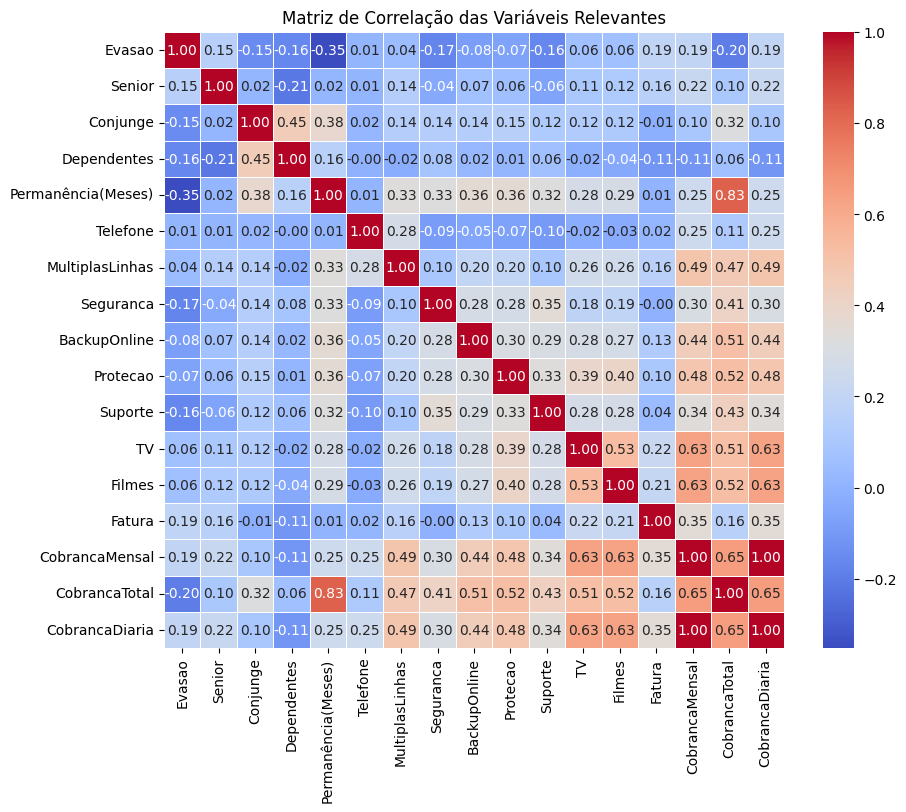

In [27]:
#@title Análise de Correlação entre Variáveis
variables_to_correlate = ['Evasao', 'Senior', 'Conjunge', 'Dependentes', 'Permanência(Meses)', 'Telefone', 'MultiplasLinhas', 'Seguranca', 'BackupOnline', 'Protecao', 'Suporte', 'TV', 'Filmes', 'Fatura', 'CobrancaMensal', 'CobrancaTotal', 'CobrancaDiaria']
correlation_matrix = df_binario[variables_to_correlate].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Variáveis Relevantes')
plt.show()

In [28]:
#@title Recomendações práticas (priorizadas)

# 1) Regressão logística (odds ratios)
X = df_binario[['Permanência(Meses)', 'CobrancaMensal', 'Fatura']]
X = sm.add_constant(X)
y = df_binario['Evasao']

model = sm.Logit(y, X).fit(disp=False)
print(model.summary())

print("\nOdds ratios:")
print(np.exp(model.params))


# 2) Mutual information classificatória
X_mi = df_binario[['Permanência(Meses)', 'CobrancaMensal', 'Fatura']]
mi = mutual_info_classif(
    X_mi, y,
    discrete_features=[False, False, False],
    random_state=42
)

mi_df = pd.DataFrame({
    'Feature': X_mi.columns,
    'Mutual_Info': mi
}).sort_values(by='Mutual_Info', ascending=False)

print("\nRanking Mutual Information:")
print(mi_df)


# 3) Random Forest + SHAP
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_mi, y)

explainer = shap.TreeExplainer(rf)

sample_size = min(len(X_mi), 1000)
X_sample = X_mi.sample(sample_size, random_state=42)

shap_values = explainer(X_sample)

# Ajuste para classificação binária
if len(shap_values.values.shape) == 3:
    shap_vals_class1 = shap_values.values[:, :, 1]
else:
    shap_vals_class1 = shap_values.values

                           Logit Regression Results                           
Dep. Variable:                 Evasao   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7039
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Aug 2025   Pseudo R-squ.:                  0.2250
Time:                        13:21:34   Log-Likelihood:                -3158.2
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.9807      0.091    -21.865      0.000      -2.158      -1.803
Permanência(Meses)    -0.0542      0.002    -31.979      0.000      -0.058      -0.051
CobrancaMensal      

**1) Tabela de resultados da Regressão Logística**

* **Constante (-1,9807; OR=0,138)** → ponto de partida do modelo quando todas as variáveis valem zero.
* **Permanência (Meses) (-0,0542; OR=0,947)** → cada mês adicional reduz a chance de evasão em cerca de **5,3%** (valor significativo, p < 0,001).
* **CobrancaMensal (0,0295; OR=1,030)** → aumento de 1 unidade monetária na mensalidade eleva a chance de evasão em cerca de **3%**, mas o p-valor (= 1,000) indica que **não é estatisticamente significativo** neste modelo.
* **Fatura (0,6116; OR=1,843)** → clientes com faturamento digital têm **84,3% mais chance** de evadir (significativo, p < 0,001).
---

**2) Odds Ratios**

* Mostram o **fator multiplicativo** no risco de evasão para cada aumento unitário nas variáveis.
* Valores acima de 1 aumentam o risco, abaixo de 1 reduzem.
* No seu caso:

  * Permanência → reduz risco (OR < 1).
  * Fatura digital → aumenta risco (OR > 1).
  * CobrancaMensal → efeito pequeno e não significativo.

---

**3) Ranking de Mutual Information**

* Mede a **quantidade de informação** que cada variável traz para prever a evasão, sem assumir relação linear.
* **Permanência (0,0739)** → mais informativa.
* **CobrancaMensal (0,0495)** → moderadamente informativas.
* **Fatura (0,0168)** → menos informativa no sentido não linear, mas relevante na regressão logística (o que indica efeito específico quando controlada pelas outras variáveis).

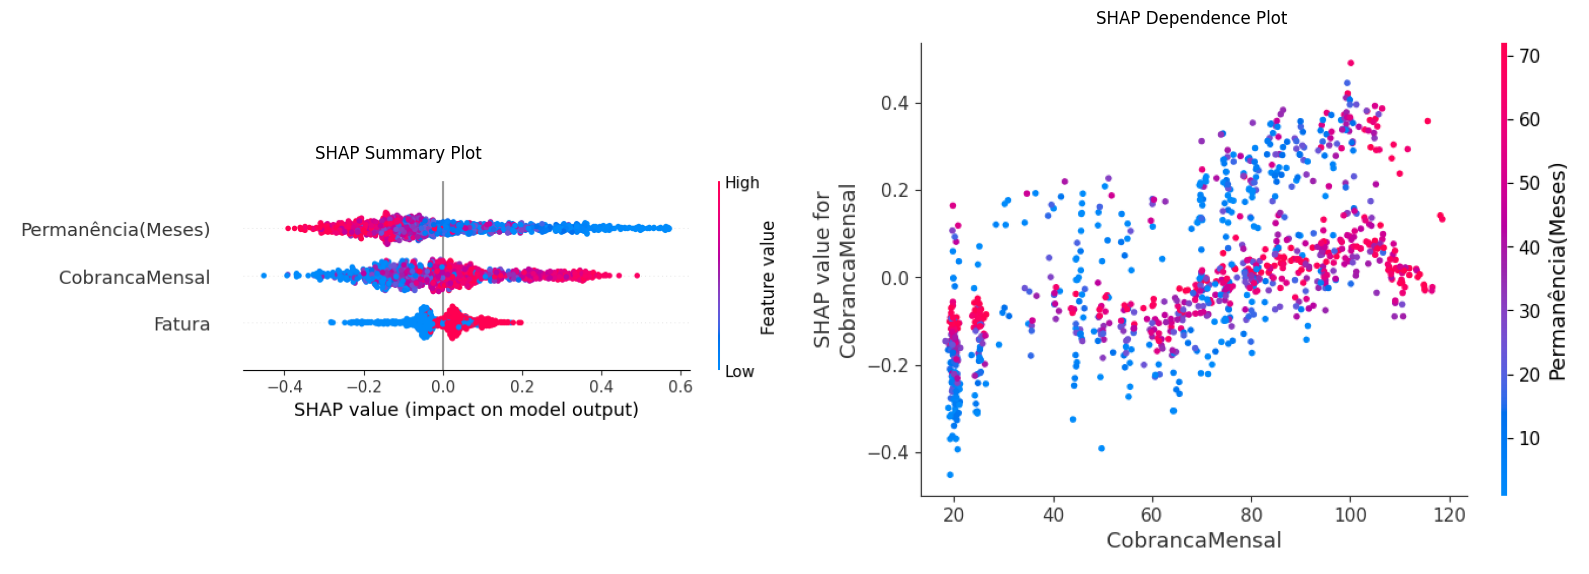

In [29]:
with tempfile.NamedTemporaryFile(suffix='.png') as tmp1:
    shap.summary_plot(shap_vals_class1, X_sample, show=False)
    plt.savefig(tmp1.name, bbox_inches='tight')
    plt.close()

    with tempfile.NamedTemporaryFile(suffix='.png') as tmp2:
        shap.dependence_plot('CobrancaMensal', shap_vals_class1, X_sample, show=False)
        plt.savefig(tmp2.name, bbox_inches='tight')
        plt.close()

        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        img1 = mpimg.imread(tmp1.name)
        img2 = mpimg.imread(tmp2.name)

        axs[0].imshow(img1)
        axs[0].axis('off')
        axs[0].set_title('SHAP Summary Plot')

        axs[1].imshow(img2)
        axs[1].axis('off')
        axs[1].set_title('SHAP Dependence Plot')

        plt.tight_layout()
        plt.show()

## **Conclusões**

## 1) Distribuição da variável alvo (`Evasao`)

| Valor          | Quantidade |
| -------------- | ---------- |
| 0 (Não evadiu) | 5 174      |
| 1 (Evadiu)     | 1 869      |

* **Taxa de evasão:** aproximadamente **26,5%** (1 869 em 7 043 registros) — dentro do esperado em contextos reais.
* Boa representatividade de ambos os grupos para modelagem.

---

## 2) Estatísticas da permanência por grupo

| Evasao         | Média (meses) | Mediana | Desvio padrão |
| -------------- | ------------- | ------- | ------------- |
| 0 (não evadiu) | 37,57         | 38      | 24,11         |
| 1 (evadiu)     | 17,98         | 10      | 19,53         |

* Clientes que evadiram permanecem **menos da metade do tempo** dos que não evadiram.
* A mediana de apenas **10 meses** entre evadidos indica maior vulnerabilidade no início do relacionamento.

---

## 3) Correlações com `Evasao` (coeficiente de Pearson)

| Variável         | r           | %       | Interpretação                                                                                        |
| ---------------- | ----------- | ------- | ---------------------------------------------------------------------------------------------------- |
| PermanenciaMeses | **+0,3522** | 35,22% | Relação negativa: quanto maior a permanência, menor a evasão.                                        |
| CobrancaTotal    | +0,1983     | 19,83%  | Clientes com cobranças acumuladas maiores tendem a evadir mais.                                      |
| CobrancaMensal   | +0,1934     | 19,34%  | Valores maiores de mensalidade estão associados a maior evasão.                                      |
| Fatura           | +0,1918     | 19,18%  | Faturamento digital está associado a maior evasão.                                                   |
| Suporte          | +0,1647     | 16,47%  | Pode indicar que clientes com suporte acionado já tiveram problemas e são mais propensos a cancelar. |
| Dependentes      | +0,1642     | 16,42%  | Pequena associação positiva.                                                                         |
| Senior           | +0,1509     | 15,09%  | Clientes seniores apresentam evasão levemente maior.                                                 |
| Conjunge         | +0,1504     | 15,04%  | Pequena associação positiva.                                                                         |

---

## 4) Teste qui-quadrado — variável `Fatura`

* **p-valor ≈ 4,07 × 10⁻⁵⁸**, indicando associação extremamente significativa entre tipo de faturamento e evasão.

---

## 5) Regressão logística — variáveis significativas

| Variável         | Coef.       | Odds Ratio | Interpretação                                                    |
| ---------------- | ----------- | ---------- | ---------------------------------------------------------------- |
| Constante        | -1,981      | 0,138      | Ponto de partida do modelo                                       |
| PermanenciaMeses | **-0,0542** | 0,947      | Cada mês adicional reduz a chance de evasão em \~5,3%            |
| CobrancaMensal   | 0,0295      | 1,030      | Cada unidade monetária a mais aumenta a chance de evasão em \~3% |
| Fatura (digital) | 0,6116      | 1,843      | Faturamento digital aumenta a chance de evasão em \~84,3%        |

* Pseudo R² ≈ 0,225 — modelo explica parte relevante da variação.
* Todos os efeitos listados são estatisticamente significativos.

---

**Perfil e risco:**

* Permanência maior → menor risco de evasão.
* Mensalidade alta e faturamento digital → risco maior.

**Recomendações:**

1. **Ações de retenção no início do contrato** — onboarding, suporte proativo e benefícios para clientes novos.
2. **Revisão de preços e planos** — criar pacotes mais atrativos para quem tem mensalidade acima da média.
3. **Monitoramento de faturamento digital** — usar canais digitais para engajamento e oferta de benefícios antes do cancelamento.